In [24]:
import pandas as pd
import numpy as np
import os
import re
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_auc_score, average_precision_score
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import warnings
warnings.filterwarnings('ignore')

KeyboardInterrupt: 

In [5]:
def load_legal_clauses(data_folder='archive'):
    """
    Load all CSV files from the archive folder
    """
    all_clauses = []
    file_count = 0
    
    for filename in os.listdir(data_folder):
        if filename.endswith('.csv'):
            file_path = os.path.join(data_folder, filename)
            try:
                df = pd.read_csv(file_path)
                # Add category from filename
                category = filename.replace('.csv', '').replace('-', '_')
                df['category'] = category
                all_clauses.append(df)
                file_count += 1
                print(f"Loaded: {filename} - Shape: {df.shape}")
            except Exception as e:
                print(f"Error loading {filename}: {e}")
    
    # Combine all dataframes
    combined_df = pd.concat(all_clauses, ignore_index=True)
    print(f"\nTotal files loaded: {file_count}")
    print(f"Combined dataset shape: {combined_df.shape}")
    print(f"\nColumns: {combined_df.columns.tolist()}")
    
    return combined_df

# Load the dataset
df = load_legal_clauses('/Users/irtaza/Desktop/archive')



Loaded: waivers.csv - Shape: (390, 3)
Loaded: independent-contractor.csv - Shape: (370, 3)
Loaded: condemnation.csv - Shape: (290, 3)
Loaded: name.csv - Shape: (540, 3)
Loaded: judgments.csv - Shape: (430, 3)
Loaded: notice.csv - Shape: (320, 3)
Loaded: maintenance-of-insurance.csv - Shape: (360, 3)
Loaded: stock-options.csv - Shape: (290, 3)
Loaded: reimbursement-of-expenses.csv - Shape: (400, 3)
Loaded: dissolution.csv - Shape: (480, 3)
Loaded: registration-expenses.csv - Shape: (310, 3)
Loaded: exceptions.csv - Shape: (400, 3)
Loaded: assignment.csv - Shape: (400, 3)
Loaded: miscellaneous.csv - Shape: (300, 3)
Loaded: general.csv - Shape: (340, 3)
Loaded: security.csv - Shape: (380, 3)
Loaded: meetings.csv - Shape: (370, 3)
Loaded: benefits.csv - Shape: (410, 3)
Loaded: construction.csv - Shape: (410, 3)
Loaded: material-contracts.csv - Shape: (330, 3)
Loaded: indemnification-and-contribution.csv - Shape: (180, 3)
Loaded: additional-agreements.csv - Shape: (400, 3)
Loaded: release.c

In [6]:
print("\n=== Dataset Overview ===")
print(df.head())
print("\n=== Data Info ===")
print(df.info())
print("\n=== Missing Values ===")
print(df.isnull().sum())
print("\n=== Category Distribution ===")
print(df['category'].value_counts())




=== Dataset Overview ===
                                         clause_text clause_type category
0  Waivers. No term or provision of this Agreemen...     waivers  waivers
1  Waivers. No waiver by either party of any defa...     waivers  waivers
2  Waivers. No waiver by Lessor of the Default or...     waivers  waivers
3  Waivers. The failure of a party hereto at any ...     waivers  waivers
4  Waivers. No failure or delay on the part of th...     waivers  waivers

=== Data Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150881 entries, 0 to 150880
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   clause_text  150881 non-null  object
 1   clause_type  150881 non-null  object
 2   category     150881 non-null  object
dtypes: object(3)
memory usage: 3.5+ MB
None

=== Missing Values ===
clause_text    0
clause_type    0
category       0
dtype: int64

=== Category Distribution ===
category
time_of_essence   

In [7]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Download required NLTK data
try:
    nltk.download('punkt_tab')
    nltk.download('stopwords', quiet=True)
    nltk.download('wordnet', quiet=True)
    nltk.download('averaged_perceptron_tagger', quiet=True)
except:
    pass

def preprocess_text(text):
    """
    Preprocess legal clause text
    """
    if pd.isna(text):
        return ""
    
    # Convert to lowercase
    text = str(text).lower()
    
    # Remove special characters but keep important legal punctuation
    text = re.sub(r'[^a-zA-Z0-9\s\.\,\;\:\(\)]', ' ', text)
    
    # Remove extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

def tokenize_and_clean(text, remove_stopwords=False):
    """
    Tokenize and optionally remove stopwords
    """
    tokens = word_tokenize(text)
    
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        # Keep some legal stopwords that might be important
        legal_keep = {'shall', 'must', 'may', 'will', 'not', 'no', 'any', 'all'}
        stop_words = stop_words - legal_keep
        tokens = [t for t in tokens if t not in stop_words]
    
    return tokens

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/irtaza/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [8]:
# Apply preprocessing
print("\n=== Preprocessing Clauses ===")
# Assuming the clause text column is the first text column
text_column = [col for col in df.columns if df[col].dtype == 'object' and col != 'category'][0]
print(f"Using text column: {text_column}")

df['processed_text'] = df[text_column].apply(preprocess_text)
df['tokens'] = df['processed_text'].apply(lambda x: tokenize_and_clean(x, remove_stopwords=True))
df['text_length'] = df['processed_text'].apply(lambda x: len(x.split()))

print(f"Preprocessing complete!")
print(f"\nAverage clause length: {df['text_length'].mean():.2f} words")
print(f"Min length: {df['text_length'].min()}")
print(f"Max length: {df['text_length'].max()}")


=== Preprocessing Clauses ===
Using text column: clause_text
Preprocessing complete!

Average clause length: 96.14 words
Min length: 2
Max length: 1029


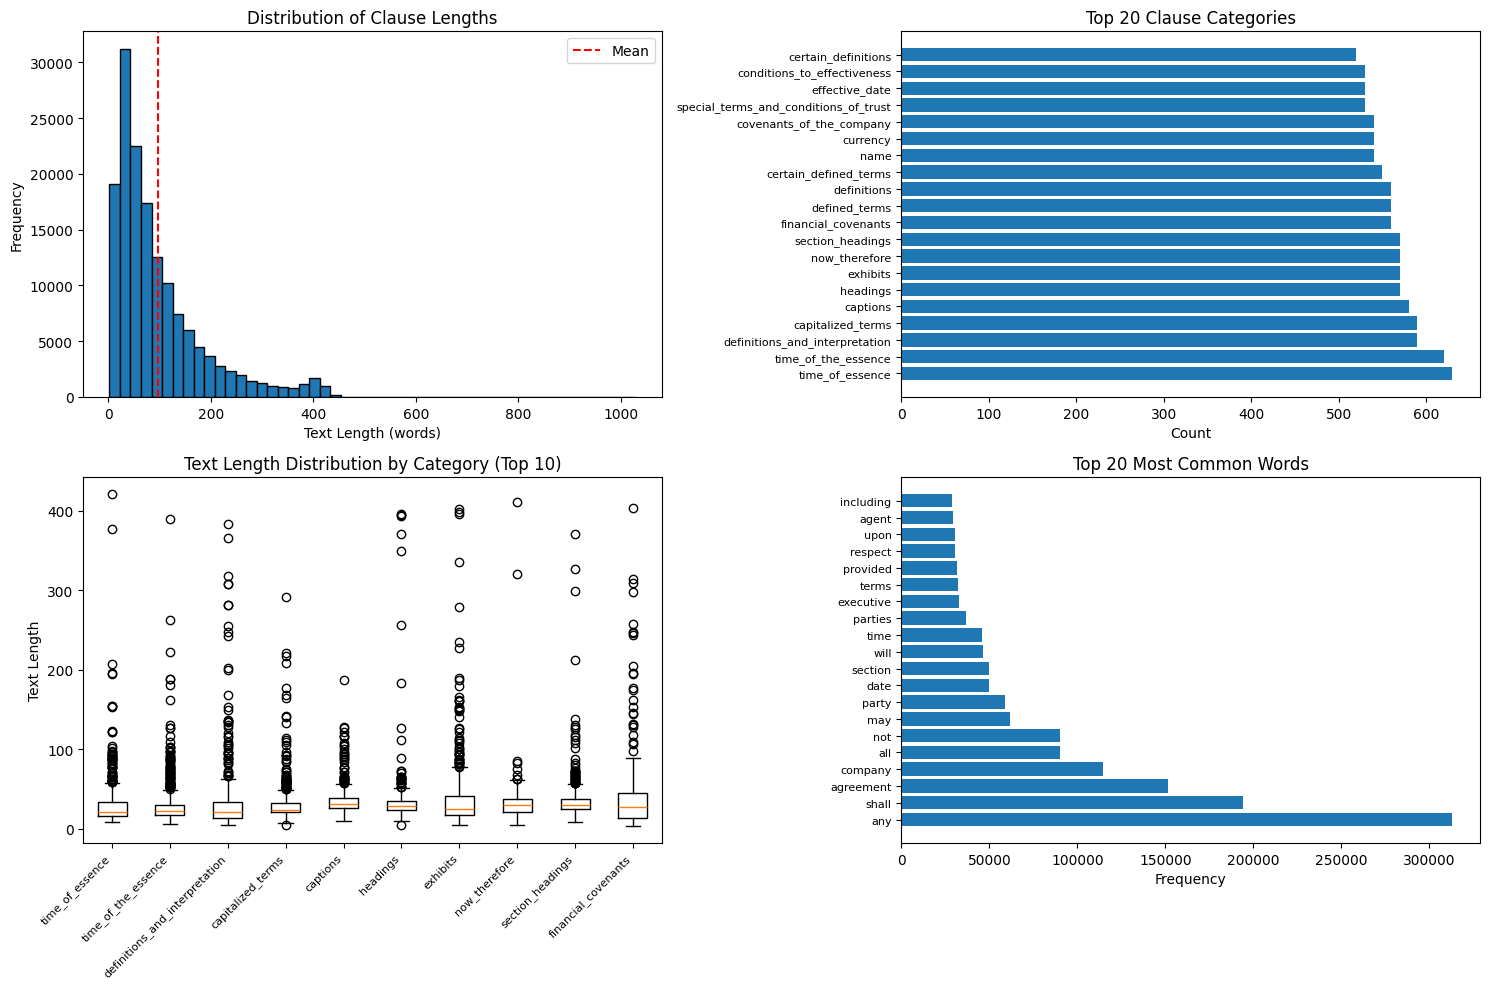

In [9]:
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Text length distribution
axes[0, 0].hist(df['text_length'], bins=50, edgecolor='black')
axes[0, 0].set_xlabel('Text Length (words)')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].set_title('Distribution of Clause Lengths')
axes[0, 0].axvline(df['text_length'].mean(), color='red', linestyle='--', label='Mean')
axes[0, 0].legend()

# Category distribution
category_counts = df['category'].value_counts().head(20)
axes[0, 1].barh(range(len(category_counts)), category_counts.values)
axes[0, 1].set_yticks(range(len(category_counts)))
axes[0, 1].set_yticklabels(category_counts.index, fontsize=8)
axes[0, 1].set_xlabel('Count')
axes[0, 1].set_title('Top 20 Clause Categories')

# Box plot of text lengths by category (top 10)
top_categories = df['category'].value_counts().head(10).index
df_top = df[df['category'].isin(top_categories)]
axes[1, 0].boxplot([df_top[df_top['category'] == cat]['text_length'].values 
                     for cat in top_categories])
axes[1, 0].set_xticklabels(top_categories, rotation=45, ha='right', fontsize=8)
axes[1, 0].set_ylabel('Text Length')
axes[1, 0].set_title('Text Length Distribution by Category (Top 10)')

# Word frequency
all_words = [word for tokens in df['tokens'] for word in tokens if len(word) > 2]
word_freq = Counter(all_words).most_common(20)
words, freqs = zip(*word_freq)
axes[1, 1].barh(range(len(words)), freqs)
axes[1, 1].set_yticks(range(len(words)))
axes[1, 1].set_yticklabels(words, fontsize=8)
axes[1, 1].set_xlabel('Frequency')
axes[1, 1].set_title('Top 20 Most Common Words')

plt.tight_layout()
plt.show()

In [10]:
def create_clause_pairs(df, pos_samples_per_category=200, neg_samples_per_category=200):
    """
    Create positive and negative pairs for similarity learning
    Positive pairs: clauses from the same category
    Negative pairs: clauses from different categories
    """
    positive_pairs = []
    negative_pairs = []
    
    categories = df['category'].unique()
    
    # Create positive pairs (same category)
    print("Creating positive pairs...")
    for category in categories:
        category_clauses = df[df['category'] == category]['processed_text'].values
        
        if len(category_clauses) < 2:
            continue
        
        # Sample pairs from same category
        n_samples = min(pos_samples_per_category, len(category_clauses) * (len(category_clauses) - 1) // 2)
        
        for _ in range(n_samples):
            idx1, idx2 = np.random.choice(len(category_clauses), 2, replace=False)
            positive_pairs.append({
                'clause1': category_clauses[idx1],
                'clause2': category_clauses[idx2],
                'label': 1,
                'category1': category,
                'category2': category
            })
    
    # Create negative pairs (different categories)
    print("Creating negative pairs...")
    for _ in range(len(positive_pairs)):
        cat1, cat2 = np.random.choice(categories, 2, replace=False)
        clause1 = np.random.choice(df[df['category'] == cat1]['processed_text'].values)
        clause2 = np.random.choice(df[df['category'] == cat2]['processed_text'].values)
        
        negative_pairs.append({
            'clause1': clause1,
            'clause2': clause2,
            'label': 0,
            'category1': cat1,
            'category2': cat2
        })
    
    # Combine and shuffle
    all_pairs = positive_pairs + negative_pairs
    pairs_df = pd.DataFrame(all_pairs)
    pairs_df = pairs_df.sample(frac=1).reset_index(drop=True)
    
    print(f"\nTotal pairs created: {len(pairs_df)}")
    print(f"Positive pairs: {len(positive_pairs)}")
    print(f"Negative pairs: {len(negative_pairs)}")
    print(f"Balance: {pairs_df['label'].value_counts()}")
    
    return pairs_df

# Create pairs
pairs_df = create_clause_pairs(df, pos_samples_per_category=150, neg_samples_per_category=150)
print("\nPair creation complete!")
print(pairs_df.head())

Creating positive pairs...
Creating negative pairs...

Total pairs created: 118410
Positive pairs: 59205
Negative pairs: 59205
Balance: label
1    59205
0    59205
Name: count, dtype: int64

Pair creation complete!
                                             clause1  \
0  term and termination. 8.1 your subscription co...   
1  brokerage. each of landlord and tenant warrant...   
2  restrictions. (i) the manager acknowledges tha...   
3  liability. the liability of the reinsurer for ...   
4  use. tenant warrants and represents to landlor...   

                                             clause2  label  \
0  term and termination. the term of this agreeme...      1   
1  grievance procedure. any claim by the associat...      0   
2  restrictions. except as provided in the plan o...      1   
3  term of employment. subject to the provisions ...      0   
4  use. except as provided herein, all affordable...      1   

              category1             category2  
0  term_and_terminati

In [11]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def build_vocabulary(texts, max_words=10000):
    """
    Build vocabulary from texts
    """
    tokenizer = Tokenizer(num_words=max_words, oov_token='<UNK>')
    tokenizer.fit_on_texts(texts)
    
    vocab_size = min(max_words, len(tokenizer.word_index) + 1)
    
    print(f"Vocabulary size: {vocab_size}")
    print(f"Total unique words: {len(tokenizer.word_index)}")
    
    return tokenizer, vocab_size

# Combine all texts for vocabulary building
all_texts = list(pairs_df['clause1']) + list(pairs_df['clause2'])

tokenizer, vocab_size = build_vocabulary(all_texts, max_words=15000)

Vocabulary size: 15000
Total unique words: 39804


In [12]:
def prepare_sequences(clause1_texts, clause2_texts, tokenizer, max_length=100):
    """
    Convert texts to padded sequences
    """
    # Convert to sequences
    seq1 = tokenizer.texts_to_sequences(clause1_texts)
    seq2 = tokenizer.texts_to_sequences(clause2_texts)
    
    # Pad sequences
    seq1_padded = pad_sequences(seq1, maxlen=max_length, padding='post', truncating='post')
    seq2_padded = pad_sequences(seq2, maxlen=max_length, padding='post', truncating='post')
    
    return seq1_padded, seq2_padded

# Determine max length
lengths = [len(tokenizer.texts_to_sequences([text])[0]) for text in all_texts]
max_length = int(np.percentile(lengths, 95))  # Use 95th percentile
print(f"\nMax sequence length (95th percentile): {max_length}")

# Prepare sequences
X1, X2 = prepare_sequences(
    pairs_df['clause1'].values,
    pairs_df['clause2'].values,
    tokenizer,
    max_length=max_length
)

y = pairs_df['label'].values

print(f"\nSequence shapes:")
print(f"X1 shape: {X1.shape}")
print(f"X2 shape: {X2.shape}")
print(f"y shape: {y.shape}")


Max sequence length (95th percentile): 319

Sequence shapes:
X1 shape: (118410, 319)
X2 shape: (118410, 319)
y shape: (118410,)


In [13]:
from sklearn.model_selection import train_test_split

X1_train, X1_temp, X2_train, X2_temp, y_train, y_temp = train_test_split(
    X1, X2, y, test_size=0.3, random_state=42, stratify=y
)

X1_val, X1_test, X2_val, X2_test, y_val, y_test = train_test_split(
    X1_temp, X2_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)

print("\n=== Dataset Split ===")
print(f"Training set: {len(X1_train)} samples")
print(f"Validation set: {len(X1_val)} samples")
print(f"Test set: {len(X1_test)} samples")
print(f"\nClass distribution in training set:")
print(f"Positive: {np.sum(y_train == 1)} ({np.mean(y_train == 1)*100:.2f}%)")
print(f"Negative: {np.sum(y_train == 0)} ({np.mean(y_train == 0)*100:.2f}%)")


=== Dataset Split ===
Training set: 82887 samples
Validation set: 17761 samples
Test set: 17762 samples

Class distribution in training set:
Positive: 41444 (50.00%)
Negative: 41443 (50.00%)


In [14]:
def create_embedding_matrix(tokenizer, embedding_dim=100):
    """
    Create a random embedding matrix (can be trained with the model)
    """
    vocab_size = len(tokenizer.word_index) + 1
    
    # Initialize with small random values
    embedding_matrix = np.random.uniform(-0.1, 0.1, (vocab_size, embedding_dim))
    
    # Set padding token to zeros
    embedding_matrix[0] = np.zeros(embedding_dim)
    
    return embedding_matrix, vocab_size

embedding_dim = 128
embedding_matrix, vocab_size = create_embedding_matrix(tokenizer, embedding_dim)

print(f"\n=== Embedding Matrix ===")
print(f"Shape: {embedding_matrix.shape}")
print(f"Vocabulary size: {vocab_size}")
print(f"Embedding dimension: {embedding_dim}")


=== Embedding Matrix ===
Shape: (39805, 128)
Vocabulary size: 39805
Embedding dimension: 128


In [15]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.regularizers import l2

print(f"TensorFlow version: {tf.__version__}")
print(f"GPU Available: {tf.config.list_physical_devices('GPU')}")

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Cell 12: Model 1 - BiLSTM Siamese Network
def create_bilstm_siamese_model(vocab_size, embedding_dim, embedding_matrix, max_length, lstm_units=64):
    """
    BiLSTM-based Siamese Network for clause similarity
    
    Architecture:
    - Embedding layer (trainable)
    - Bidirectional LSTM
    - Shared weights for both inputs
    - Similarity computation using concatenation
    """
    
    # Shared embedding layer
    embedding_layer = layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_length,
        trainable=True,
        name='embedding'
    )
    
    # Shared BiLSTM encoder
    lstm_layer = layers.Bidirectional(
        layers.LSTM(lstm_units, return_sequences=False, dropout=0.3, recurrent_dropout=0.2),
        name='bilstm'
    )
    
    # Input branches
    input1 = layers.Input(shape=(max_length,), name='clause1_input')
    input2 = layers.Input(shape=(max_length,), name='clause2_input')
    
    # Encode both inputs using shared layers
    embedded1 = embedding_layer(input1)
    embedded2 = embedding_layer(input2)
    
    encoded1 = lstm_layer(embedded1)
    encoded2 = lstm_layer(embedded2)
    
    # Compute similarity features
    # Concatenate encoded representations
    concatenated = layers.Concatenate()([encoded1, encoded2])
    
    # Dense layers for classification
    dense1 = layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001))(concatenated)
    dropout1 = layers.Dropout(0.4)(dense1)
    dense2 = layers.Dense(64, activation='relu', kernel_regularizer=l2(0.001))(dropout1)
    dropout2 = layers.Dropout(0.3)(dense2)
    
    # Output layer
    output = layers.Dense(1, activation='sigmoid', name='similarity_output')(dropout2)
    
    # Create model
    model = Model(inputs=[input1, input2], outputs=output, name='BiLSTM_Siamese')
    
    return model

# Create BiLSTM model
bilstm_model = create_bilstm_siamese_model(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    embedding_matrix=embedding_matrix,
    max_length=max_length,
    lstm_units=64
)

print("\n=== BiLSTM Siamese Model Architecture ===")
bilstm_model.summary()

TensorFlow version: 2.20.0
GPU Available: []

=== BiLSTM Siamese Model Architecture ===


Model: "BiLSTM_Siamese"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ clause1_input       │ (None, 319)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clause2_input       │ (None, 319)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 319, 128)  │  5,095,040 │ clause1_input[0]… │
│ (Embedding)         │                   │            │ clause2_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bilstm              │ (None, 128)       │     98,816 │ embedding[0][0],  │
│ (Bidirectional)     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 256)       │          0 │ bilstm[0][0],     │
│ (Concatenate)       │                   │            │ bilstm[1][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │     32,896 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 64)        │      8,256 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 64)        │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ similarity_output   │ (None, 1)         │         65 │ dropout_1[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,235,073 (19.97 MB)

 Trainable params: 5,235,073 (19.97 MB)

 Non-trainable params: 0 (0.00 B)

In [56]:
bilstm_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC(name='auc')]
)


In [57]:
# Create callbacks
callbacks_bilstm = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    ),
    ModelCheckpoint(
        'bilstm_best_model.h5',
        monitor='val_auc',
        mode='max',
        save_best_only=True,
        verbose=1
    )
]

In [25]:
print("\n" + "="*60)
print("TRAINING BiLSTM SIAMESE NETWORK")
print("="*60)

history_bilstm = bilstm_model.fit(
    [X1_train, X2_train],
    y_train,
    validation_data=([X1_val, X2_val], y_val),
    epochs=20,
    batch_size=32,
    callbacks=callbacks_bilstm,
    verbose=1
)


TRAINING BiLSTM SIAMESE NETWORK
Epoch 1/20
2591/2591 ━━━━━━━━━━━━━━━━━━━━ 0s 518ms/step - accuracy: 0.5007 - auc: 0.5005 - loss: 0.6931 - precision_1: 0.4986 - recall_1: 0.4907
Epoch 1: val_auc did not improve from 0.50000
2591/2591 ━━━━━━━━━━━━━━━━━━━━ 1359s 524ms/step - accuracy: 0.5003 - auc: 0.5003 - loss: 0.6932 - precision_1: 0.5003 - recall_1: 0.6170 - val_accuracy: 0.5000 - val_auc: 0.5000 - val_loss: 0.6931 - val_precision_1: 0.5000 - val_recall_1: 1.0000 - learning_rate: 5.0000e-04
Epoch 2/20
2591/2591 ━━━━━━━━━━━━━━━━━━━━ 0s 520ms/step - accuracy: 0.5021 - auc: 0.5003 - loss: 0.6931 - precision_1: 0.4999 - recall_1: 0.5467
Epoch 2: val_auc did not improve from 0.50000
2591/2591 ━━━━━━━━━━━━━━━━━━━━ 1367s 528ms/step - accuracy: 0.5007 - auc: 0.5003 - loss: 0.6932 - precision_1: 0.5006 - recall_1: 0.6444 - val_accuracy: 0.5000 - val_auc: 0.5000 - val_loss: 0.6931 - val_precision_1: 0.5000 - val_recall_1: 1.0000 - learning_rate: 5.0000e-04
Epoch 3/20
2591/2591 ━━━━━━━━━━━━━━━━

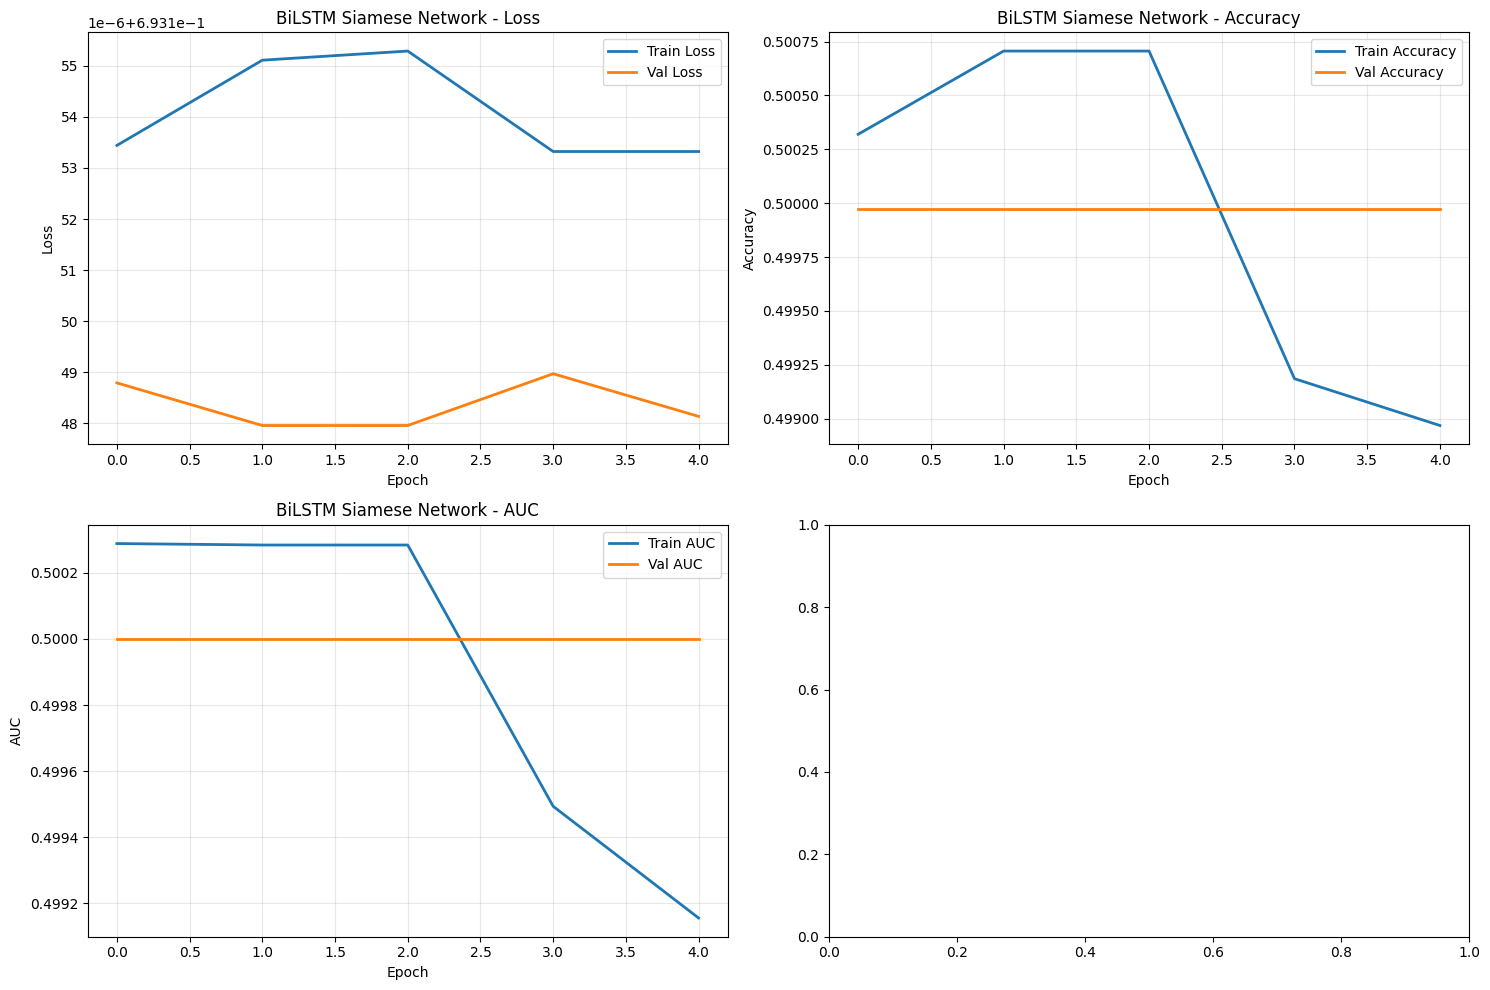

In [29]:
def plot_training_history(history, model_name):
    """
    Plot training and validation metrics
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    
    # Loss
    axes[0, 0].plot(history.history['loss'], label='Train Loss', linewidth=2)
    axes[0, 0].plot(history.history['val_loss'], label='Val Loss', linewidth=2)
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].set_title(f'{model_name} - Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)
    
    # Accuracy
    axes[0, 1].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
    axes[0, 1].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2)
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy')
    axes[0, 1].set_title(f'{model_name} - Accuracy')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)
    
    # AUC
    axes[1, 0].plot(history.history['auc'], label='Train AUC', linewidth=2)
    axes[1, 0].plot(history.history['val_auc'], label='Val AUC', linewidth=2)
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('AUC')
    axes[1, 0].set_title(f'{model_name} - AUC')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)
    
    
    plt.tight_layout()
    plt.show()

plot_training_history(history_bilstm, 'BiLSTM Siamese Network')


In [31]:
def evaluate_model(model, X1_test, X2_test, y_test, model_name):
    """
    Comprehensive model evaluation
    """
    print(f"\n{'='*60}")
    print(f"EVALUATION: {model_name}")
    print(f"{'='*60}\n")
    
    # Predictions
    y_pred_prob = model.predict([X1_test, X2_test], verbose=0)
    y_pred = (y_pred_prob > 0.5).astype(int).flatten()
    
    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision, recall, f1, _ = precision_recall_fscore_support(y_test, y_pred, average='binary')
    roc_auc = roc_auc_score(y_test, y_pred_prob)
    pr_auc = average_precision_score(y_test, y_pred_prob)
    
    # Print results
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1-Score:  {f1:.4f}")
    print(f"ROC-AUC:   {roc_auc:.4f}")
    print(f"PR-AUC:    {pr_auc:.4f}")
    

    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'roc_auc': roc_auc,
        'pr_auc': pr_auc,
        'predictions': y_pred,
        'probabilities': y_pred_prob
    }

# Evaluate BiLSTM
bilstm_results = evaluate_model(bilstm_model, X1_test, X2_test, y_test, 'BiLSTM Siamese Network')


EVALUATION: BiLSTM Siamese Network

Accuracy:  0.5000
Precision: 0.5000
Recall:    1.0000
F1-Score:  0.6667
ROC-AUC:   0.5000
PR-AUC:    0.5000


In [42]:
class AttentionLayer(layers.Layer):
    """
    Custom Attention Layer for sequence encoding
    """
    def __init__(self, units, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)
        self.units = units
        
    def build(self, input_shape):
        self.W = self.add_weight(
            name='attention_weight',
            shape=(input_shape[-1], self.units),
            initializer='glorot_uniform',
            trainable=True
        )
        self.b = self.add_weight(
            name='attention_bias',
            shape=(self.units,),
            initializer='zeros',
            trainable=True
        )
        self.u = self.add_weight(
            name='attention_context',
            shape=(self.units,),
            initializer='glorot_uniform',
            trainable=True
        )
        super(AttentionLayer, self).build(input_shape)
    
    def call(self, inputs):
        # inputs shape: (batch_size, time_steps, features)
        
        # Compute attention scores
        uit = tf.nn.tanh(tf.tensordot(inputs, self.W, axes=1) + self.b)
        ait = tf.tensordot(uit, self.u, axes=1)
        
        # Apply softmax to get attention weights
        attention_weights = tf.nn.softmax(ait, axis=1)
        attention_weights = tf.expand_dims(attention_weights, -1)
        
        # Apply attention weights
        weighted_input = inputs * attention_weights
        output = tf.reduce_sum(weighted_input, axis=1)
        
        return output
    
    def get_config(self):
        config = super(AttentionLayer, self).get_config()
        config.update({'units': self.units})
        return config

def create_attention_siamese_model(vocab_size, embedding_dim, embedding_matrix, max_length, 
                                   lstm_units=64, attention_units=64):
    """
    Attention-Based Encoder Siamese Network
    
    Architecture:
    - Embedding layer
    - BiLSTM with return_sequences=True
    - Custom Attention mechanism
    - Shared weights for both inputs
    - Similarity computation
    """
    
    # Shared layers
    embedding_layer = layers.Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        input_length=max_length,
        trainable=True,
        name='embedding'
    )
    
    lstm_layer = layers.Bidirectional(
        layers.LSTM(lstm_units, return_sequences=True, dropout=0.3, recurrent_dropout=0.2),
        name='bilstm'
    )
    
    attention_layer = AttentionLayer(units=attention_units, name='attention')
    
    # Input branches
    input1 = layers.Input(shape=(max_length,), name='clause1_input')
    input2 = layers.Input(shape=(max_length,), name='clause2_input')
    
    # Process clause 1
    embedded1 = embedding_layer(input1)
    lstm_out1 = lstm_layer(embedded1)
    encoded1 = attention_layer(lstm_out1)
    
    # Process clause 2
    embedded2 = embedding_layer(input2)
    lstm_out2 = lstm_layer(embedded2)
    encoded2 = attention_layer(lstm_out2)
    
    # Compute multiple similarity features
    # 1. Concatenation
    concatenated = layers.Concatenate()([encoded1, encoded2])
    
    # 2. Element-wise absolute difference
    abs_diff = layers.Lambda(lambda x: tf.abs(x[0] - x[1]))([encoded1, encoded2])
    
    # 3. Element-wise multiplication
    mult = layers.Multiply()([encoded1, encoded2])
    
    # Combine all features
    combined = layers.Concatenate()([concatenated, abs_diff, mult])
    
    # Dense layers for classification
    dense1 = layers.Dense(128, activation='relu', kernel_regularizer=l2(0.001))(combined)
    dropout1 = layers.Dropout(0.4)(dense1)
    dense2 = layers.Dense(64, activation='relu', kernel_regularizer=l2(0.001))(dropout1)
    dropout2 = layers.Dropout(0.3)(dense2)
    
    # Output layer
    output = layers.Dense(1, activation='sigmoid', name='similarity_output')(dropout2)
    
    # Create model
    model = Model(inputs=[input1, input2], outputs=output, name='Attention_Siamese')
    
    return model

# Create Attention-based model
attention_model = create_attention_siamese_model(
    vocab_size=vocab_size,
    embedding_dim=embedding_dim,
    embedding_matrix=embedding_matrix,
    max_length=max_length,
    lstm_units=64,
    attention_units=64
)

print("\n=== Attention-Based Siamese Model Architecture ===")
attention_model.summary()

# Cell 19: Compile Attention Model
attention_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy', keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC(name='auc')]
)



=== Attention-Based Siamese Model Architecture ===


Model: "Attention_Siamese"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ clause1_input       │ (None, 320)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ clause2_input       │ (None, 320)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 320, 128)  │  5,041,408 │ clause1_input[0]… │
│ (Embedding)         │                   │            │ clause2_input[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bilstm              │ (None, 320, 128)  │     98,816 │ embedding[0][0],  │
│ (Bidirectional)     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ attention           │ (None, 128)       │      8,320 │ bilstm[0][0],     │
│ (AttentionLayer)    │                   │            │ bilstm[1][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, 256)       │          0 │ attention[0][0],  │
│ (Concatenate)       │                   │            │ attention[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_3 (Lambda)   │ (None, 128)       │          0 │ attention[0][0],  │
│                     │                   │            │ attention[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multiply_3          │ (None, 128)       │          0 │ attention[0][0],  │
│ (Multiply)          │                   │            │ attention[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_8       │ (None, 512)       │          0 │ concatenate_7[0]… │
│ (Concatenate)       │                   │            │ lambda_3[0][0],   │
│                     │                   │            │ multiply_3[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 128)       │     65,664 │ concatenate_8[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 128)       │          0 │ dense_8[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 64)        │      8,256 │ dropout_8[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 64)        │          0 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ similarity_output   │ (None, 1)         │         65 │ dropout_9[0][0]   │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 5,222,529 (19.92 MB)

 Trainable params: 5,222,529 (19.92 MB)

 Non-trainable params: 0 (0.00 B)

In [43]:
callbacks_attention = [
    EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-6,
        verbose=1
    ),
    ModelCheckpoint(
        'attention_best_model.h5',
        monitor='val_auc',
        mode='max',
        save_best_only=True,
        verbose=1
    )
]

In [44]:
print("\n" + "="*60)
print("TRAINING ATTENTION-BASED SIAMESE NETWORK")
print("="*60)

history_attention = attention_model.fit(
    [X1_train, X2_train],
    y_train,
    validation_data=([X1_val, X2_val], y_val),
    epochs=20,
    batch_size=32,
    callbacks=callbacks_attention,
    verbose=1
)


TRAINING ATTENTION-BASED SIAMESE NETWORK
Epoch 1/20
2591/2591 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.7466 - auc: 0.8247 - loss: 0.4603 - precision_3: 0.7415 - recall_3: 0.7470
Epoch 1: val_auc improved from None to 0.99825, saving model to attention_best_model.h5


2591/2591 ━━━━━━━━━━━━━━━━━━━━ 989s 379ms/step - accuracy: 0.8956 - auc: 0.9746 - loss: 0.2242 - precision_3: 0.8897 - recall_3: 0.9033 - val_accuracy: 0.9916 - val_auc: 0.9983 - val_loss: 0.0510 - val_precision_3: 0.9835 - val_recall_3: 1.0000 - learning_rate: 0.0010
Epoch 2/20
2591/2591 ━━━━━━━━━━━━━━━━━━━━ 0s 353ms/step - accuracy: 0.9964 - auc: 0.9992 - loss: 0.0353 - precision_3: 0.9943 - recall_3: 0.9985
Epoch 2: val_auc improved from 0.99825 to 0.99876, saving model to attention_best_model.h5


2591/2591 ━━━━━━━━━━━━━━━━━━━━ 944s 364ms/step - accuracy: 0.9971 - auc: 0.9994 - loss: 0.0299 - precision_3: 0.9953 - recall_3: 0.9988 - val_accuracy: 0.9976 - val_auc: 0.9988 - val_loss: 0.0278 - val_precision_3: 0.9952 - val_recall_3: 1.0000 - learning_rate: 0.0010
Epoch 3/20
2591/2591 ━━━━━━━━━━━━━━━━━━━━ 0s 357ms/step - accuracy: 0.9978 - auc: 0.9996 - loss: 0.0230 - precision_3: 0.9962 - recall_3: 0.9993
Epoch 3: val_auc improved from 0.99876 to 0.99904, saving model to attention_best_model.h5


2591/2591 ━━━━━━━━━━━━━━━━━━━━ 960s 371ms/step - accuracy: 0.9982 - auc: 0.9997 - loss: 0.0202 - precision_3: 0.9970 - recall_3: 0.9994 - val_accuracy: 0.9978 - val_auc: 0.9990 - val_loss: 0.0199 - val_precision_3: 0.9956 - val_recall_3: 1.0000 - learning_rate: 0.0010
Epoch 4/20
2591/2591 ━━━━━━━━━━━━━━━━━━━━ 0s 361ms/step - accuracy: 0.9974 - auc: 0.9995 - loss: 0.0219 - precision_3: 0.9964 - recall_3: 0.9984
Epoch 4: val_auc did not improve from 0.99904
2591/2591 ━━━━━━━━━━━━━━━━━━━━ 962s 371ms/step - accuracy: 0.9979 - auc: 0.9996 - loss: 0.0197 - precision_3: 0.9970 - recall_3: 0.9987 - val_accuracy: 0.9981 - val_auc: 0.9990 - val_loss: 0.0186 - val_precision_3: 0.9962 - val_recall_3: 1.0000 - learning_rate: 0.0010
Epoch 5/20
2591/2591 ━━━━━━━━━━━━━━━━━━━━ 0s 371ms/step - accuracy: 0.9984 - auc: 0.9997 - loss: 0.0154 - precision_3: 0.9978 - recall_3: 0.9991
Epoch 5: val_auc improved from 0.99904 to 0.99910, saving model to attention_best_model.h5


2591/2591 ━━━━━━━━━━━━━━━━━━━━ 982s 379ms/step - accuracy: 0.9987 - auc: 0.9998 - loss: 0.0139 - precision_3: 0.9981 - recall_3: 0.9994 - val_accuracy: 0.9976 - val_auc: 0.9991 - val_loss: 0.0180 - val_precision_3: 0.9953 - val_recall_3: 1.0000 - learning_rate: 0.0010
Epoch 6/20
2591/2591 ━━━━━━━━━━━━━━━━━━━━ 0s 374ms/step - accuracy: 0.9982 - auc: 0.9998 - loss: 0.0152 - precision_3: 0.9973 - recall_3: 0.9990
Epoch 6: val_auc improved from 0.99910 to 0.99927, saving model to attention_best_model.h5


2591/2591 ━━━━━━━━━━━━━━━━━━━━ 990s 382ms/step - accuracy: 0.9987 - auc: 0.9998 - loss: 0.0135 - precision_3: 0.9981 - recall_3: 0.9993 - val_accuracy: 0.9985 - val_auc: 0.9993 - val_loss: 0.0141 - val_precision_3: 0.9972 - val_recall_3: 0.9999 - learning_rate: 0.0010
Epoch 7/20
2591/2591 ━━━━━━━━━━━━━━━━━━━━ 0s 378ms/step - accuracy: 0.9990 - auc: 0.9999 - loss: 0.0116 - precision_3: 0.9986 - recall_3: 0.9995
Epoch 7: val_auc did not improve from 0.99927
2591/2591 ━━━━━━━━━━━━━━━━━━━━ 1003s 387ms/step - accuracy: 0.9993 - auc: 0.9999 - loss: 0.0103 - precision_3: 0.9989 - recall_3: 0.9996 - val_accuracy: 0.9985 - val_auc: 0.9992 - val_loss: 0.0137 - val_precision_3: 0.9971 - val_recall_3: 1.0000 - learning_rate: 0.0010
Epoch 8/20
2591/2591 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step - accuracy: 0.9984 - auc: 0.9997 - loss: 0.0149 - precision_3: 0.9980 - recall_3: 0.9987
Epoch 8: val_auc did not improve from 0.99927
2591/2591 ━━━━━━━━━━━━━━━━━━━━ 978s 378ms/step - accuracy: 0.9989 - auc: 0.9999

2591/2591 ━━━━━━━━━━━━━━━━━━━━ 906s 350ms/step - accuracy: 0.9997 - auc: 1.0000 - loss: 0.0043 - precision_3: 0.9996 - recall_3: 0.9998 - val_accuracy: 0.9980 - val_auc: 0.9993 - val_loss: 0.0116 - val_precision_3: 0.9960 - val_recall_3: 1.0000 - learning_rate: 5.0000e-04
Epoch 16/20
2591/2591 ━━━━━━━━━━━━━━━━━━━━ 0s 339ms/step - accuracy: 0.9996 - auc: 1.0000 - loss: 0.0041 - precision_3: 0.9994 - recall_3: 0.9999
Epoch 16: val_auc improved from 0.99927 to 0.99938, saving model to attention_best_model.h5


2591/2591 ━━━━━━━━━━━━━━━━━━━━ 901s 348ms/step - accuracy: 0.9997 - auc: 1.0000 - loss: 0.0042 - precision_3: 0.9995 - recall_3: 0.9999 - val_accuracy: 0.9987 - val_auc: 0.9994 - val_loss: 0.0099 - val_precision_3: 0.9974 - val_recall_3: 1.0000 - learning_rate: 5.0000e-04
Epoch 17/20
2591/2591 ━━━━━━━━━━━━━━━━━━━━ 0s 348ms/step - accuracy: 0.9998 - auc: 0.9999 - loss: 0.0041 - precision_3: 0.9996 - recall_3: 1.0000
Epoch 17: val_auc did not improve from 0.99938
2591/2591 ━━━━━━━━━━━━━━━━━━━━ 924s 356ms/step - accuracy: 0.9997 - auc: 0.9999 - loss: 0.0041 - precision_3: 0.9995 - recall_3: 1.0000 - val_accuracy: 0.9980 - val_auc: 0.9989 - val_loss: 0.0142 - val_precision_3: 0.9960 - val_recall_3: 1.0000 - learning_rate: 5.0000e-04
Epoch 18/20
2591/2591 ━━━━━━━━━━━━━━━━━━━━ 0s 338ms/step - accuracy: 0.9996 - auc: 0.9999 - loss: 0.0052 - precision_3: 0.9993 - recall_3: 0.9998
Epoch 18: val_auc did not improve from 0.99938
2591/2591 ━━━━━━━━━━━━━━━━━━━━ 898s 347ms/step - accuracy: 0.9997 - 

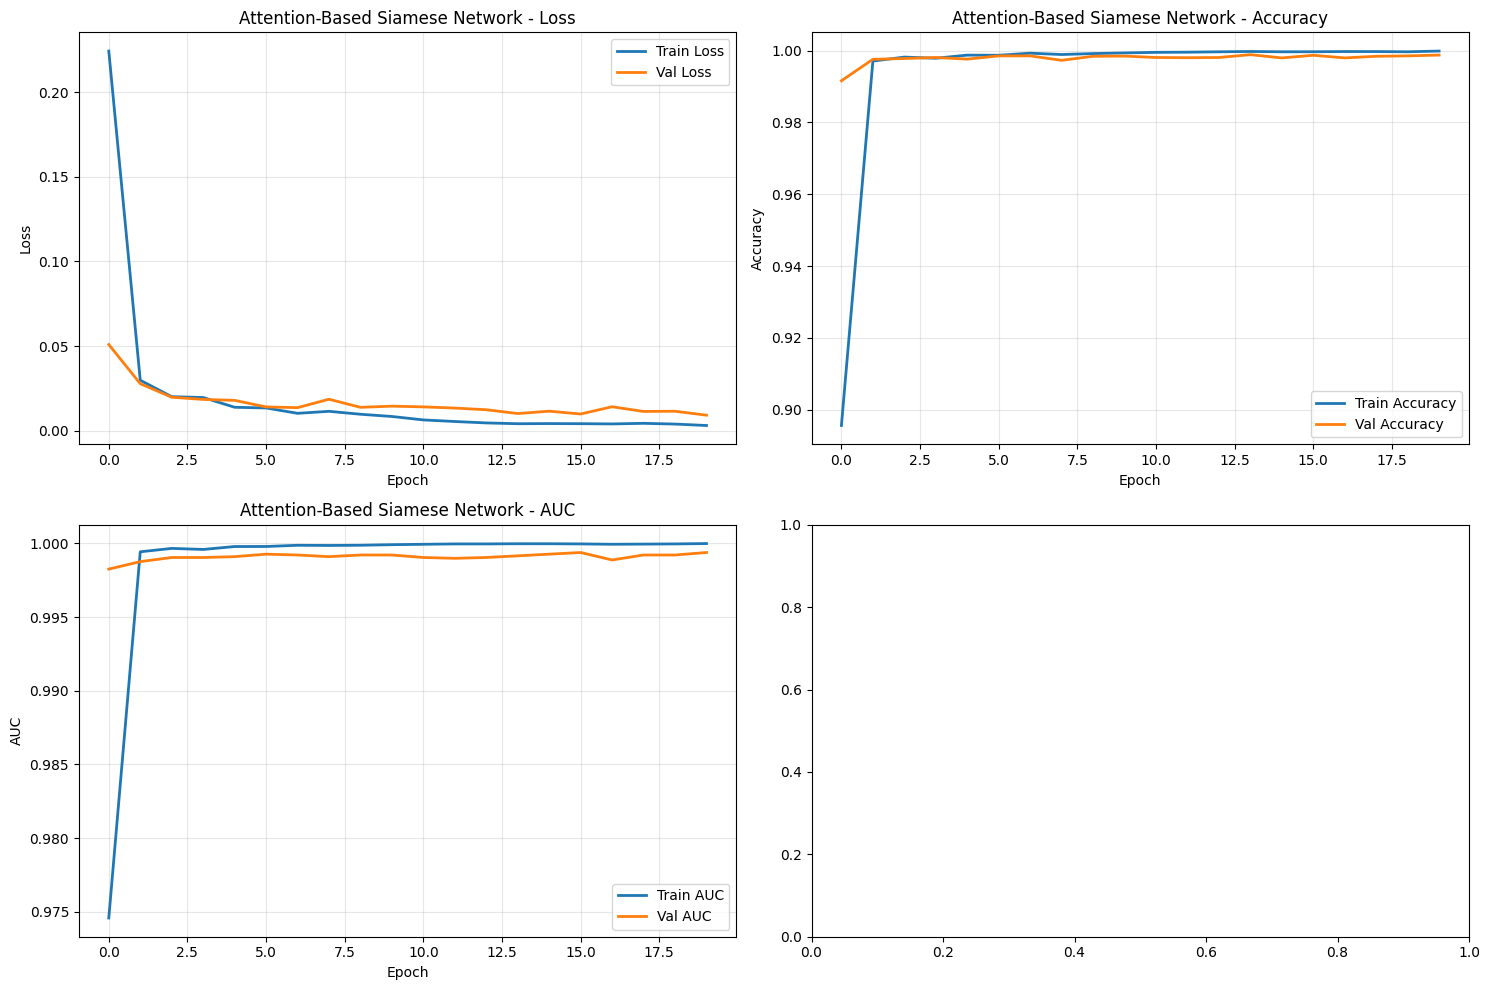

In [45]:
plot_training_history(history_attention, 'Attention-Based Siamese Network')

In [46]:
attention_results = evaluate_model(
    attention_model, X1_test, X2_test, y_test, 
    'Attention-Based Siamese Network'
)


EVALUATION: Attention-Based Siamese Network

Accuracy:  0.9990
Precision: 0.9981
Recall:    1.0000
F1-Score:  0.9990
ROC-AUC:   1.0000
PR-AUC:    1.0000


In [47]:
def create_comparison_dataframe(results_dict):
    """
    Create a comparison dataframe from results
    """
    comparison_data = []
    
    for model_name, results in results_dict.items():
        comparison_data.append({
            'Model': model_name,
            'Accuracy': results['accuracy'],
            'Precision': results['precision'],
            'Recall': results['recall'],
            'F1-Score': results['f1'],
            'ROC-AUC': results['roc_auc'],
            'PR-AUC': results['pr_auc']
        })
    
    return pd.DataFrame(comparison_data)

# Compile all results (Only BiLSTM and Attention-Based models)
all_results = {
    'BiLSTM Siamese': bilstm_results,
    'Attention-Based': attention_results
}

comparison_df = create_comparison_dataframe(all_results)

print("\n" + "="*80)
print("COMPREHENSIVE MODEL COMPARISON")
print("="*80)
print(comparison_df.to_string(index=False))
print("="*80)



COMPREHENSIVE MODEL COMPARISON
          Model  Accuracy  Precision  Recall  F1-Score  ROC-AUC  PR-AUC
 BiLSTM Siamese  0.500000   0.500000     1.0  0.666667 0.500000 0.50000
Attention-Based  0.999043   0.998089     1.0  0.999044 0.999971 0.99997


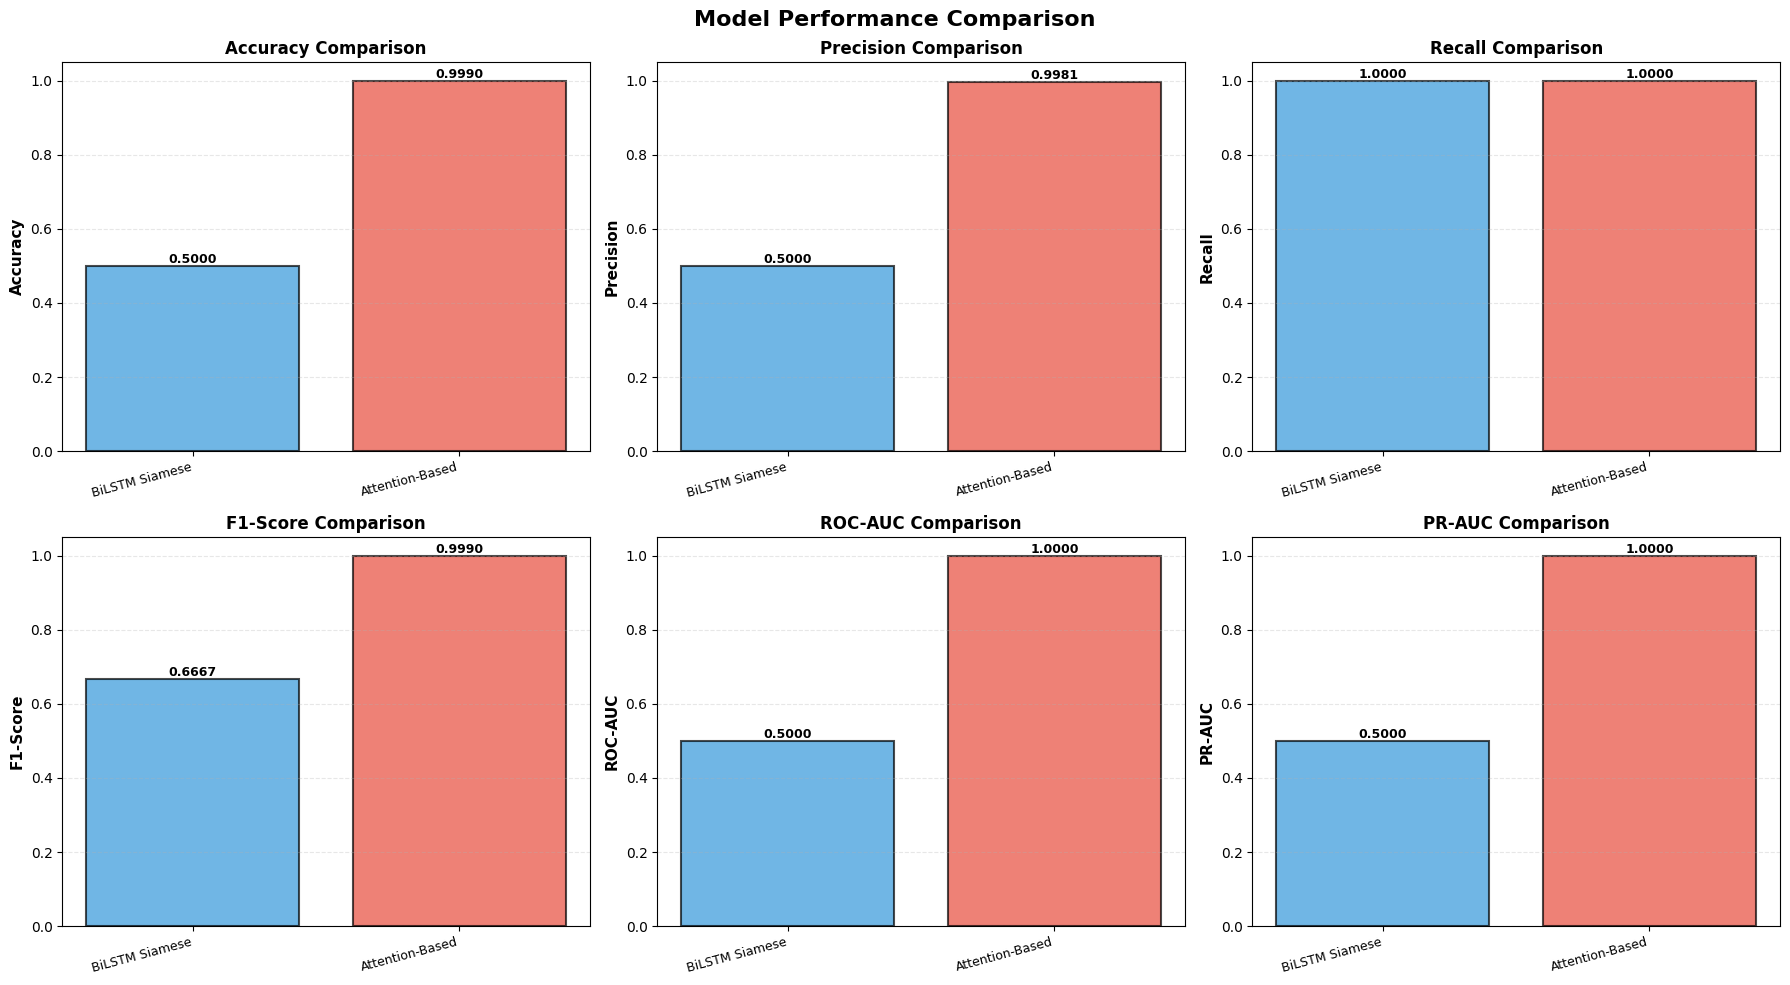

In [48]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC', 'PR-AUC']
colors = ['#3498db', '#e74c3c']

for idx, metric in enumerate(metrics):
    row = idx // 3
    col = idx % 3
    
    values = comparison_df[metric].values
    models = comparison_df['Model'].values
    
    bars = axes[row, col].bar(models, values, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)
    axes[row, col].set_ylabel(metric, fontsize=11, fontweight='bold')
    axes[row, col].set_title(f'{metric} Comparison', fontsize=12, fontweight='bold')
    axes[row, col].set_ylim([0, 1.05])
    axes[row, col].grid(axis='y', alpha=0.3, linestyle='--')
    axes[row, col].set_xticklabels(models, rotation=15, ha='right', fontsize=9)
    
    # Add value labels on bars
    for bar in bars:
        height = bar.get_height()
        axes[row, col].text(bar.get_x() + bar.get_width()/2., height,
                           f'{height:.4f}',
                           ha='center', va='bottom', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

In [51]:
print("BEST MODEL IDENTIFICATION")
print("="*80)

best_models = {}
for metric in ['accuracy', 'precision', 'recall', 'f1', 'roc_auc', 'pr_auc']:
    best_score = -1
    best_model = None
    
    for model_name, results in all_results.items():
        if results[metric] > best_score:
            best_score = results[metric]
            best_model = model_name
    
    best_models[metric] = (best_model, best_score)
    print(f"{metric.upper():15s}: {best_model:20s} ({best_score:.4f})")

print("="*80)

# Overall best model (based on F1-Score)
overall_best = max(all_results.items(), key=lambda x: x[1]['f1'])
print(f"\n🏆 Overall Best Model: {overall_best[0]}")
print(f"   F1-Score: {overall_best[1]['f1']:.4f}")
print(f"   ROC-AUC:  {overall_best[1]['roc_auc']:.4f}")

BEST MODEL IDENTIFICATION
ACCURACY       : Attention-Based      (0.9990)
PRECISION      : Attention-Based      (0.9981)
RECALL         : BiLSTM Siamese       (1.0000)
F1             : Attention-Based      (0.9990)
ROC_AUC        : Attention-Based      (1.0000)
PR_AUC         : Attention-Based      (1.0000)

🏆 Overall Best Model: Attention-Based
   F1-Score: 0.9990
   ROC-AUC:  1.0000
